In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [44]:
data = mipt.read_excel('data/data.xlsx', usecols=(0, 1, 2, 3, 4, 5, 6 ,7 ,8, 9, 10, 11, 12, 13, 14, 15), header=(0,1))
#data['Ra']
data

Ra                                    Th_Am                     \
            elem channel resolution    square        elem channel resolution   
0  Ra^{226}_{88}    1640  24.331704  2.203331  Th^{x}_{x}  1622.0    15.7952   
1  Po^{210}_{84}    1815  22.576647  0.472037  Th^{x}_{x}  1894.0    17.1208   
2  Rn^{222}_{86}    1881  23.968700  2.536300         NaN     NaN        NaN   
3  Po^{218}_{84}    2055  21.054200  2.040600         NaN     NaN        NaN   
4  Po^{214}_{84}    2617  22.499200  2.033200         NaN     NaN        NaN   

                      Pu                                        U          \
   square           elem channel resolution  square          elem channel   
0  2.1286     Pu^{x}_{x}  1788.0    16.8127  6.2065  U^{238}_{92}  1400.0   
1  2.5141  Pu^{238}_{94}  1894.0    20.8960  0.1610  U^{234}_{92}  1629.0   
2     NaN            NaN     NaN        NaN     NaN           NaN     NaN   
3     NaN            NaN     NaN        NaN     NaN           NaN     NaN   
4     NaN            NaN     NaN        NaN     NaN           NaN     NaN   

                      
  resolution  square  
0    87.9598  0.9578  
1    43.1976  1.0393  
2        NaN     NaN  
3        NaN     NaN  
4        NaN     NaN

In [45]:
Ra = mipt.read_excel('data/ra.xlsx', usecols=(0,1), header=(0))
Ra

,Channel,Counts
0,1.0,0.0
1,2.0,0.0
2,3.0,0.0
3,4.0,0.0
4,5.0,0.0
...,...,...
4091,4092.0,0.0
4092,4093.0,0.0
4093,4094.0,0.0
4094,4095.0,0.0


$$ a = (2.97 \pm 0.01) \cdot 10^{-3} \; \frac{ \text{МэВ} }{ \text{кан.} }$$
$$ b = (-0.10 \pm 0.02) \; \text{МэВ}$$


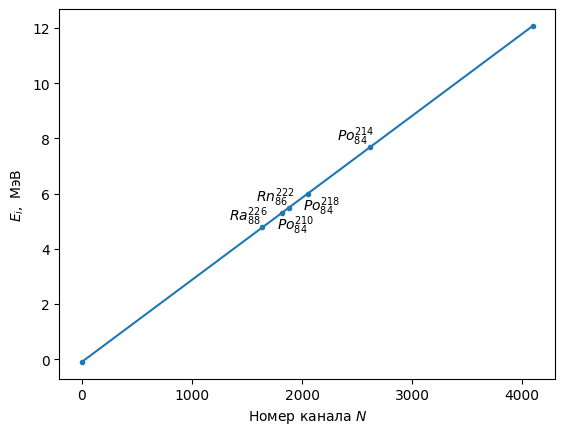

In [55]:
data = mipt.read_excel('data/data.xlsx', usecols=(0, 1, 2, 3, 4, 5, 6 ,7 ,8, 9, 10, 11, 12, 13, 14, 15), header=(0,1))

energy = np.array([4.784, 5.304, 5.490, 6.002, 7.687])
channels = data['Ra']['channel'].dropna()
elems = data['Ra']['elem']

X = channels
Y = energy
#_x, _y, equ = mipt.plot(X, Y)

for i in range(X.size):
    label = "${}$".format(elems[i])

    distx = -10
    disty = 5
    if (i % 2 == 1):
        disty = -12
        distx = 10
    #distx = 0
    #disty = 10
    #if (i == X.size - 1):
    #    disty = -20

    plt.annotate(label, # this is the text
                 (X[i], Y[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(distx,disty), # distance from text to points (x,y)
                 ha='center',
                 zorder=-1) # horizontal alignment can be left, right or center


energy_coeff = mipt.mnk(X, Y).data['a'][0]
energy_coeff_err = mipt.mnk(X, Y).data['da'][0]

#print('\$\\alpha = {:.2f} \\pm {:.2f} \\frac\{\\text\{МэВ\}\}\{кан.\}\$'.format(energy_coeff, energy_coeff_err))


mnk_tab = mipt.mnk(X, Y).data

A = mnk_tab['a'][0]
B = mnk_tab['b'][0]
dA = mnk_tab['da'][0]
dB = mnk_tab['db'][0]

print('$$ a = ({:.2f} \\pm {:.2f}) \\cdot 10^{{-3}} \\; \\frac{{ \\text{{МэВ}} }}{{ \\text{{кан.}} }}$$'
      .format(A * 1000, dA * 1000))

print('$$ b = ({:.2f} \\pm {:.2f}) \\; \\text{{МэВ}}$$'
      .format(B, dB))

#(energy_coeff * 2055 - 6.002) / 6.002


def calc_energy(x, dx):
    return A*x + B, np.linalg.norm([x*dA, dB, A*dx])

mnk_tab

X = np.array([0] + list(X) + [4096])
Y = np.array([B] + list(Y) + [A * 4096 + B])
_x, _y, equ = mipt.plot(X, Y)

#mnk_tab.to_latex('gen/')

plt.xlabel(r"Номер канала $N$")
plt.ylabel(r"$E_i,$ МэВ")

# plt.legend()
plt.savefig('gen/fig-w-channel.pdf')

In [47]:


def process_data_for_single_elem(file, name, export_name, fr, to):
    El = mipt.read_excel(file, usecols=(0,1), header=(0))
    
    x = El['Channel'][fr:to]
    y = El['Counts'][fr:to]
    
    elems = data[name]['elem'].dropna()
    x_pikes = data[name]['channel'].dropna()
    print(elems)
    y_pikes = np.array(list(y[x_pikes])) # Awesome!!!

    resolution = data[name]['resolution'].dropna()
    energy_resolution = resolution * A
    energy_resolution_err = energy_resolution * dA / A

    arr_energy = []
    arr_energy_err = []
    arr_denergy_err = []

    for i in range(x_pikes.size):

        energ, energ_err = calc_energy(x_pikes[i], 0)
        label = "${}$\n${:.2f} \\pm {:.2f}$ МэВ".format(elems[i], energ, energ_err)
        arr_energy.append(energ)
        arr_energy_err.append(energ_err)
        arr_denergy_err.append(dA * resolution[i])
        plt.annotate(label, # this is the text
                     (x_pikes[i], y_pikes[i]), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

        plt.axvline(x = x_pikes[i], color = 'purple', zorder=14, lw=1, ls='-.')


    plt.errorbar(x_pikes, y_pikes, color='purple', zorder=16, xerr = 0, fmt='o', ms=0.2)
    plt.plot(x, y)

    arr_energy = np.array(arr_energy)
    arr_energy_err = np.array(arr_energy_err)
    arr_denergy_err = np.array(arr_denergy_err)
    arr_denergy = np.array(resolution * A)
    R = arr_denergy / arr_energy
    dR = R * np.sqrt((arr_denergy_err/arr_denergy)**2 + (arr_energy_err/arr_energy)**2)
    R_f = 1 / np.sqrt(arr_energy / 3.6e-6)
    arr_epsilon = arr_energy_err / arr_energy
    
    energy_df = pd.DataFrame(arr_energy, columns = ['E_i']) 
    energy_err_df = pd.DataFrame(arr_energy_err, columns = ['E_i_err'])
    denergy_df = pd.DataFrame(arr_denergy, columns = ['dE_i'])
    denergy_err_df = pd.DataFrame(arr_denergy_err, columns = ['dE_i_err'])
    R_df = pd.DataFrame(R, columns = ['R_i'])
    R_f_df = pd.DataFrame(R_f, columns = ['R_{f,i}'])
    epsilon_df = pd.DataFrame(arr_epsilon, columns = ['epsilon'])
    #R_err_df = pd.DataFrame(dR, columns = ['R_i_err'])

    
    
    export = pd.concat([
        x_pikes.rename('N_i'),
        resolution.rename('dN_i'),
        energy_df,
        epsilon_df,
        #energy_err_df,
        denergy_df,
        #denergy_err_df,
        R_df,
        R_f_df,
    ], axis=1)

    fmt = {
        'N_i' : [r'$N_i$', '{:.0f}', 0],
        'dN_i' : [r'$\Delta N_i$', '{:.2f}', 0],
        'E_i' : [r'$E_i$, МэВ', '{:.2f}', 0],
        'E_i_err' : [r'$\sigma_{E_i}$, МэВ', '{:.2f}', 0],
        'dE_i' : [r'$\Delta E_i$, МэВ', '{:.4f}', 0],
        'dE_i_err' : [r'$\sigma_{\Delta E_i}$, МэВ', '{:.4f}', 0],
        'R_i' : [r'$R_i \cdot 10^2$', '{:.2f}', 2],
        'R_i_err' : [r'$\sigma_{R_i}$', '{:.3f}', 0],
        'R_{f,i}' : [r'$R_{f,i} \cdot 10^2$', '{:.3f}', 2],
        'epsilon' : [r'$\varepsilon_{E_i}, \%$', '{:.1f}', 2],
    }

    tab = mipt.table(export, fmt)
    tab.to_latex('gen/tab-{}.tex'.format(export_name))
    tab.rename().data

    plt.xlabel(r"Номер канала  N")
    plt.ylabel(r"Количество зарегистрированных частиц")

    plt.savefig('gen/fig-{}.pdf'.format(export_name))

    return tab.rename().data    

0    Ra^{226}_{88}
1    Po^{210}_{84}
2    Rn^{222}_{86}
3    Po^{218}_{84}
4    Po^{214}_{84}
Name: elem, dtype: object


,$N_i$,$\Delta N_i$,"$E_i$, МэВ","$\varepsilon_{E_i}, \%$","$\Delta E_i$, МэВ",$R_i \cdot 10^2$,"$R_{f,i} \cdot 10^2$"
0,1640,24.331704,4.778701,0.005992,0.072315,0.015133,0.000868
1,1815,22.576647,5.298812,0.005639,0.067099,0.012663,0.000824
2,1881,23.968700,5.494969,0.005526,0.071237,0.012964,0.000809
3,2055,21.054200,6.012108,0.005272,0.062574,0.010408,0.000774
4,2617,22.499200,7.682410,0.004731,0.066869,0.008704,0.000685


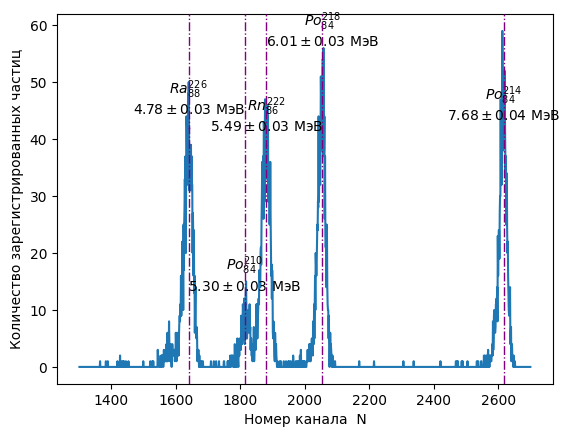

In [48]:
tab = process_data_for_single_elem(
    file = 'data/ra.xlsx',
    name = 'Ra',
    fr = 1300,
    to = 2700,
    export_name = 'ra'
)

tab

0    Th^{x}_{x}
1    Th^{x}_{x}
Name: elem, dtype: object


,$N_i$,$\Delta N_i$,"$E_i$, МэВ","$\varepsilon_{E_i}, \%$","$\Delta E_i$, МэВ",$R_i \cdot 10^2$,"$R_{f,i} \cdot 10^2$"
0,1622.0,15.7952,4.725203,0.006034,0.046944,0.009935,0.000873
1,1894.0,17.1208,5.533606,0.005505,0.050884,0.009195,0.000807


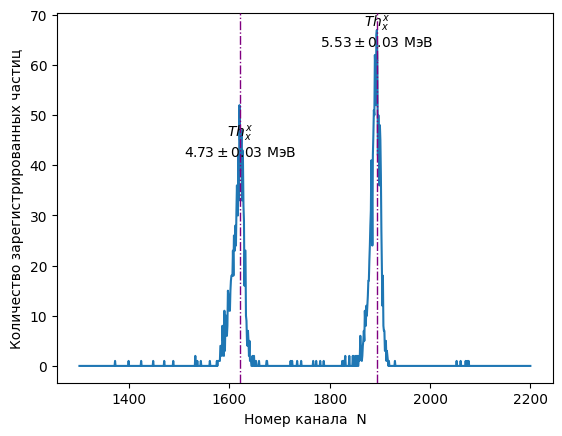

In [49]:
tab = process_data_for_single_elem(
    file = 'data/th_am.xlsx',
    name = 'Th_Am',
    fr = 1300,
    to = 2200,
    export_name = 'th_am'
)

tab

0       Pu^{x}_{x}
1    Pu^{238}_{94}
Name: elem, dtype: object


,$N_i$,$\Delta N_i$,"$E_i$, МэВ","$\varepsilon_{E_i}, \%$","$\Delta E_i$, МэВ",$R_i \cdot 10^2$,"$R_{f,i} \cdot 10^2$"
0,1788.0,16.8127,5.218567,0.005688,0.049968,0.009575,0.000831
1,1894.0,20.8960,5.533606,0.005505,0.062104,0.011223,0.000807


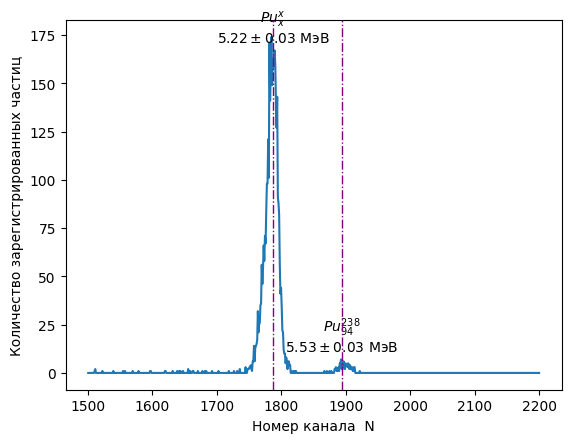

In [50]:
tab = process_data_for_single_elem(
    file = 'data/pu.xlsx',
    name = 'Pu',
    fr = 1500,
    to = 2200,
    export_name = 'pu'
)

tab

0    U^{238}_{92}
1    U^{234}_{92}
Name: elem, dtype: object


,$N_i$,$\Delta N_i$,"$E_i$, МэВ","$\varepsilon_{E_i}, \%$","$\Delta E_i$, МэВ",$R_i \cdot 10^2$,"$R_{f,i} \cdot 10^2$"
0,1400.0,87.9598,4.065405,0.006655,0.261422,0.064304,0.000941
1,1629.0,43.1976,4.746008,0.006017,0.128386,0.027051,0.000871


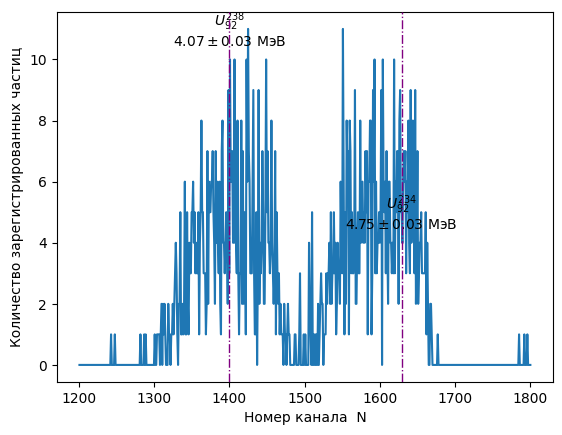

In [51]:
tab = process_data_for_single_elem(
    file = 'data/u.xlsx',
    name = 'U',
    fr = 1200,
    to = 1800,
    export_name = 'u'
)

tab

,$N_i$,$dN_i$,"$E_i$, МэВ","$\sigma_{E_i}$, МэВ","$\Delta E_i$, МэВ","$\sigma_{\Delta E_i}$, МэВ"
0,1640,24.331704,4.778701,0.028634,0.072315,0.000267
1,1815,22.576647,5.298812,0.029879,0.067099,0.000248
2,1881,23.968700,5.494969,0.030366,0.071237,0.000263
3,2055,21.054200,6.012108,0.031695,0.062574,0.000231
4,2617,22.499200,7.682410,0.036343,0.066869,0.000247


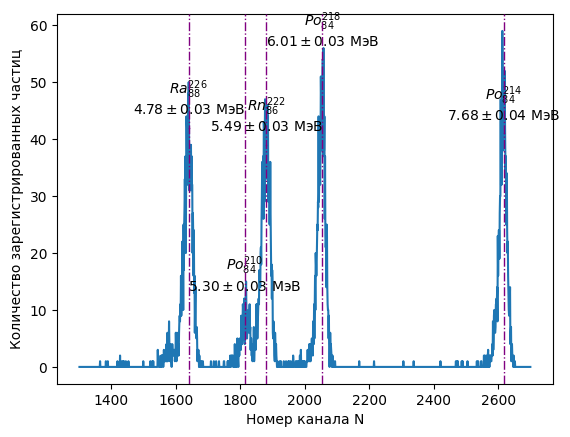

In [52]:
name = 'Ra'
tabfile = 'ra'
file = 'data/ra.xlsx'
fr = 1300
to = 2700

x = Ra['Channel'][fr:to]
y = Ra['Counts'][fr:to]

elem_data = mipt.read_excel(file, usecols=(0,1), header=(0))
elems = data[name]['elem']
x_pikes = data[name]['channel'].dropna()
y_pikes = np.array(list(y[x_pikes])) # Awesome!!!

resolution = data['Ra']['resolution']
energy_resolution = resolution * A
energy_resolution_err = energy_resolution * dA / A

arr_energy = []
arr_energy_err = []
arr_denergy_err = []

for i in range(x_pikes.size):
    
    energ, energ_err = calc_energy(x_pikes[i], 0)
    label = "${}$\n${:.2f} \\pm {:.2f}$ МэВ".format(elems[i], energ, energ_err)
    arr_energy.append(energ)
    arr_energy_err.append(energ_err)
    arr_denergy_err.append(dA * resolution[i])
    plt.annotate(label, # this is the text
                 (x_pikes[i], y_pikes[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
    plt.axvline(x = x_pikes[i], color = 'purple', zorder=14, lw=1, ls='-.')


plt.errorbar(x_pikes, y_pikes, color='purple', zorder=16, xerr = 0, fmt='o', ms=0.2)
plt.plot(x, y)

arr_energy = np.array(arr_energy)
arr_energy_err = np.array(arr_energy_err)
arr_denergy_err = np.array(arr_denergy_err)
arr_denergy = np.array(resolution * A)

energy_df = pd.DataFrame(arr_energy, columns = ['E_i']) 
energy_err_df = pd.DataFrame(arr_energy_err, columns = ['E_i_err'])
denergy_df = pd.DataFrame(arr_denergy, columns = ['dE_i'])
denergy_err_df = pd.DataFrame(arr_denergy_err, columns = ['dE_i_err'])



export = pd.concat([
    x_pikes.rename('N_i'),
    resolution.rename('dN_i'),
    energy_df,
    energy_err_df,
    denergy_df,
    denergy_err_df,
], axis=1)

fmt = {
    'N_i' : [r'$N_i$', '{:.1f}', 0],
    'dN_i' : [r'$dN_i$', '{:.2f}', 0],
    'E_i' : [r'$E_i$, МэВ', '{:.2f}', 0],
    'E_i_err' : [r'$\sigma_{E_i}$, МэВ', '{:.2f}', 0],
    'dE_i' : [r'$\Delta E_i$, МэВ', '{:.4f}', 0],
    'dE_i_err' : [r'$\sigma_{\Delta E_i}$, МэВ', '{:.4f}', 0],
}

tab = mipt.table(export, fmt)
tab.to_latex('gen/tab-{}.tex'.format(tabfile))
tab.rename().data


plt.xlabel(r"Номер канала N")
plt.ylabel(r"Количество зарегистрированных частиц")

plt.savefig('gen/fig-{}.pdf'.format(tabfile))

tab.rename().data

# Проверка

$$ \rho = \frac{ \cov_{ xy } }{ \sigma_x \cdot \sigma_y} = 0.9964 $$


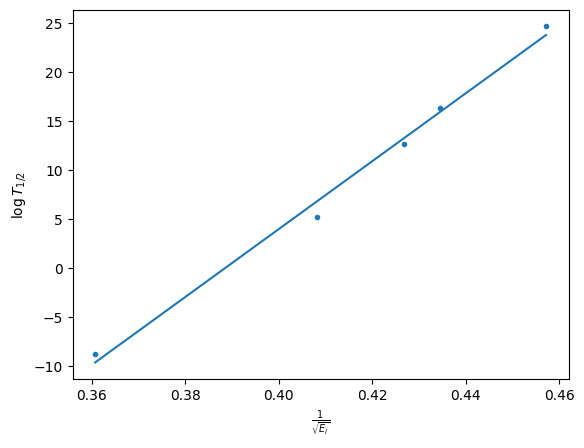

In [53]:
te_data = mipt.read_excel('data/te.xlsx', usecols=(0,1), header=(0))

y = np.log(te_data['T'])
x = 1/np.sqrt(te_data['E'])

mipt.plot(x, y)

plt.xlabel(r"$\frac{1}{\sqrt{E_i}}$")
plt.ylabel(r"$\log{T_{1/2}}$")

plt.savefig('gen/fig-te.pdf')

mnk = mipt.mnk(x, y)
mnkd = mnk.data

r = mnkd['rxy'] / (mnkd['sx'] * mnkd['sy'])**0.5


print('$$ \\rho = \\frac{{ \\cov_{{ xy }} }}{{ \\sigma_x \\cdot \\sigma_y}} = {:.4f} $$'.format(r[0]))

In [54]:
y_pikes = data['Ra']['channel'].dropna()
y_pikes[0]

1640